In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import DenseNet201  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

In [2]:
# Define the path to the data directory
data_dir = "C:/Users/HP/Desktop/terminal-data"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


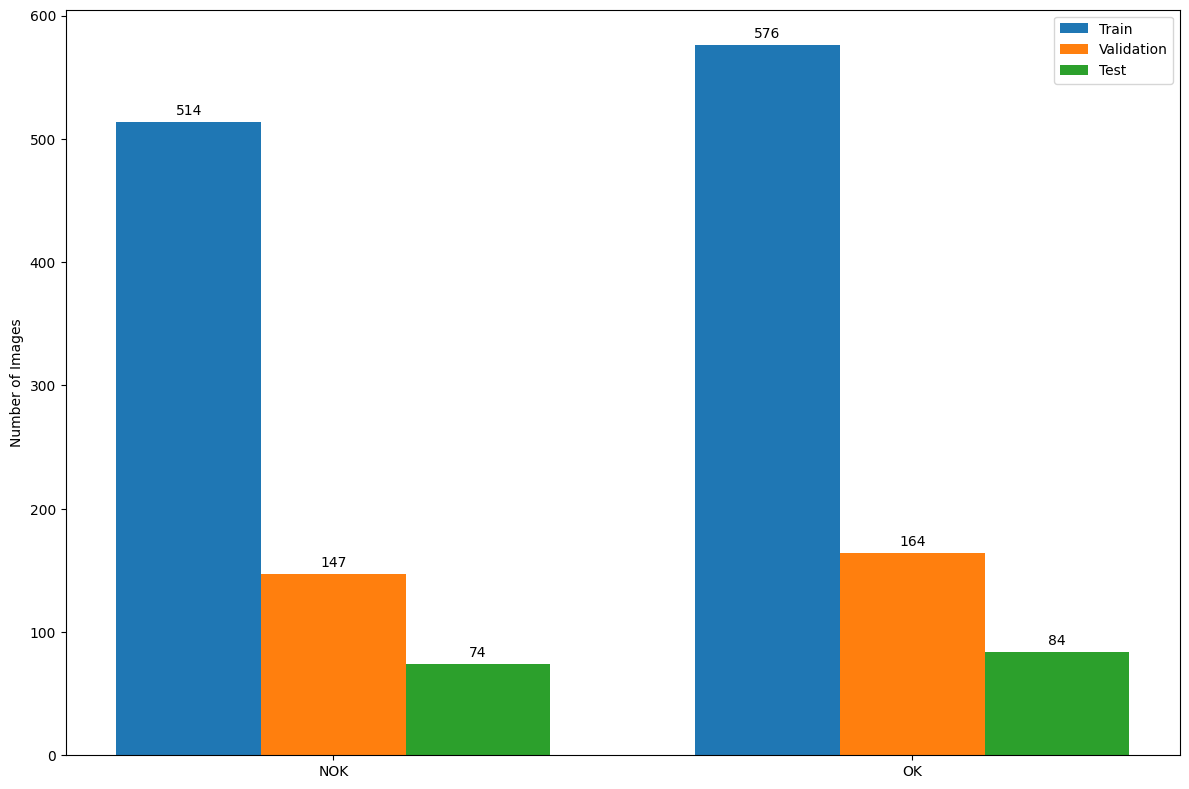

In [4]:
visualize_data(train_dir, val_dir, test_dir)

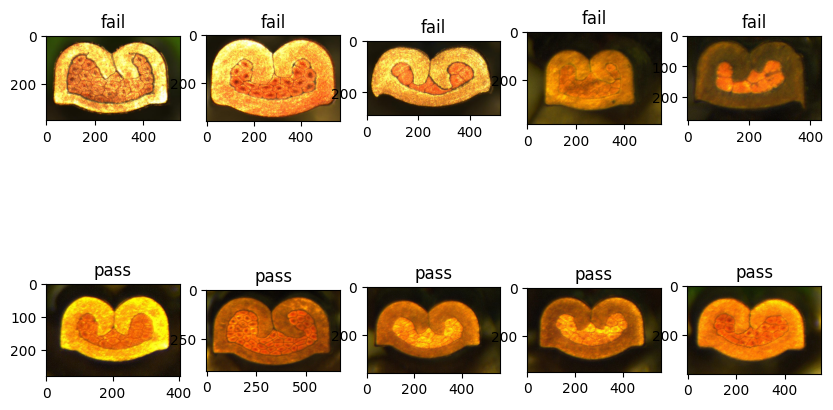

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("fail")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("pass")

plt.show()

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1090 images belonging to 2 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 311 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 158 images belonging to 2 classes.


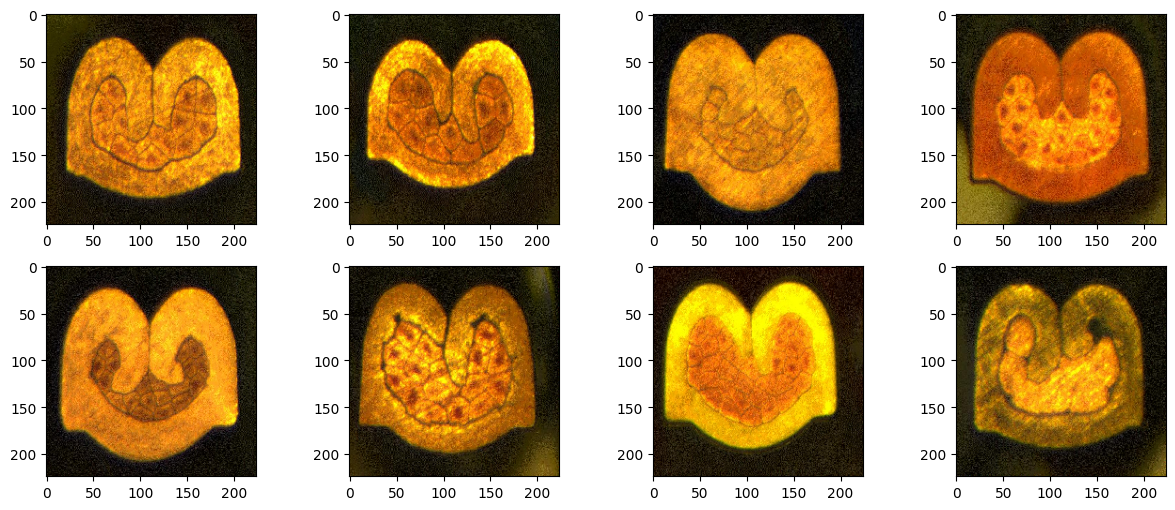

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 1.0603112840466926, 1: 0.9461805555555556}

In [13]:
base_model = DenseNet201(
        weights='imagenet', 
        include_top=False, 
        input_shape=(img_width, img_height, 3) 
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000025A921C7E20>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000025A929D2D70>,zero_padding2d,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A929D3040>,conv1/conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000025A929D36A0>,conv1/bn,False
4,<keras.layers.core.activation.Activation object at 0x0000025A929D3400>,conv1/relu,False
...,...,...,...
704,<keras.layers.merging.concatenate.Concatenate object at 0x0000025B0FA060E0>,conv5_block32_concat,False
705,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000025B0FA07580>,bn,False
706,<keras.layers.core.activation.Activation object at 0x0000025B0FA04580>,relu,False
707,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000025A921C7DF0>,global_average_pooling2d,True


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [17]:
recall = Recall()
precision = Precision()

In [18]:
#optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [19]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [20]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10
136/136 [==============================] - 16s 74ms/step - loss: 0.6954 - accuracy: 0.7209 - recall: 0.7382 - precision: 0.7357 - val_loss: 0.5504 - val_accuracy: 0.7434 - val_recall: 0.5404 - val_precision: 0.9560
Epoch 2/10
136/136 [==============================] - 8s 56ms/step - loss: 0.3510 - accuracy: 0.8438 - recall: 0.8497 - precision: 0.8541 - val_loss: 0.3108 - val_accuracy: 0.8816 - val_recall: 0.9321 - val_precision: 0.8580
Epoch 3/10
136/136 [==============================] - 8s 56ms/step - loss: 0.2376 - accuracy: 0.8983 - recall: 0.9159 - precision: 0.8940 - val_loss: 0.2458 - val_accuracy: 0.9013 - val_recall: 0.9438 - val_precision: 0.8779
Epoch 4/10
136/136 [==============================] - 8s 56ms/step - loss: 0.2046 - accuracy: 0.9131 - recall: 0.9213 - precision: 0.9149 - val_loss: 0.2252 - val_accuracy: 0.8980 - val_recall: 0.9438 - val_precision: 0.8728
Epoch 5/10
136/136 [==============================] - 8s 56ms/step - loss: 0.1792 - accuracy: 0.932

In [21]:
len(base_model.layers)

707

In [22]:
for layer in base_model.layers:
  layer.trainable = True

In [23]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [24]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000025A921C7E20>,input_1,True
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000025A929D2D70>,zero_padding2d,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025A929D3040>,conv1/conv,True
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000025A929D36A0>,conv1/bn,True
4,<keras.layers.core.activation.Activation object at 0x0000025A929D3400>,conv1/relu,True
...,...,...,...
704,<keras.layers.merging.concatenate.Concatenate object at 0x0000025B0FA060E0>,conv5_block32_concat,True
705,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000025B0FA07580>,bn,True
706,<keras.layers.core.activation.Activation object at 0x0000025B0FA04580>,relu,True
707,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000025A921C7DF0>,global_average_pooling2d,True


In [25]:
df['Layer Trainable'].value_counts()[True]

709

In [26]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [27]:
#reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [28]:
checkpoint_cb = ModelCheckpoint('model.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [29]:
csv_logger = CSVLogger('training_log.csv')

In [30]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb, checkpoint_cb, csv_logger],
                      class_weight=class_weight_dict
                   )

Epoch 1/100
136/136 [==============================] - 38s 188ms/step - loss: 1.7690 - accuracy: 0.6802 - recall: 0.7268 - precision: 0.7655 - val_loss: 2.0228 - val_accuracy: 0.5197 - val_recall: 0.1437 - val_precision: 0.7188
Epoch 2/100
136/136 [==============================] - 23s 169ms/step - loss: 0.5467 - accuracy: 0.7865 - recall: 0.8101 - precision: 0.7922 - val_loss: 0.4014 - val_accuracy: 0.7993 - val_recall: 0.7791 - val_precision: 0.8355
Epoch 3/100
136/136 [==============================] - 22s 161ms/step - loss: 0.3590 - accuracy: 0.8503 - recall: 0.8494 - precision: 0.8645 - val_loss: 0.6021 - val_accuracy: 0.7533 - val_recall: 0.5741 - val_precision: 0.9394
Epoch 4/100
136/136 [==============================] - 22s 161ms/step - loss: 0.2739 - accuracy: 0.8909 - recall: 0.8899 - precision: 0.9025 - val_loss: 2.1591 - val_accuracy: 0.7632 - val_recall: 0.8994 - val_precision: 0.7186
Epoch 5/100
136/136 [==============================] - 22s 164ms/step - loss: 0.5301 - a

In [31]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

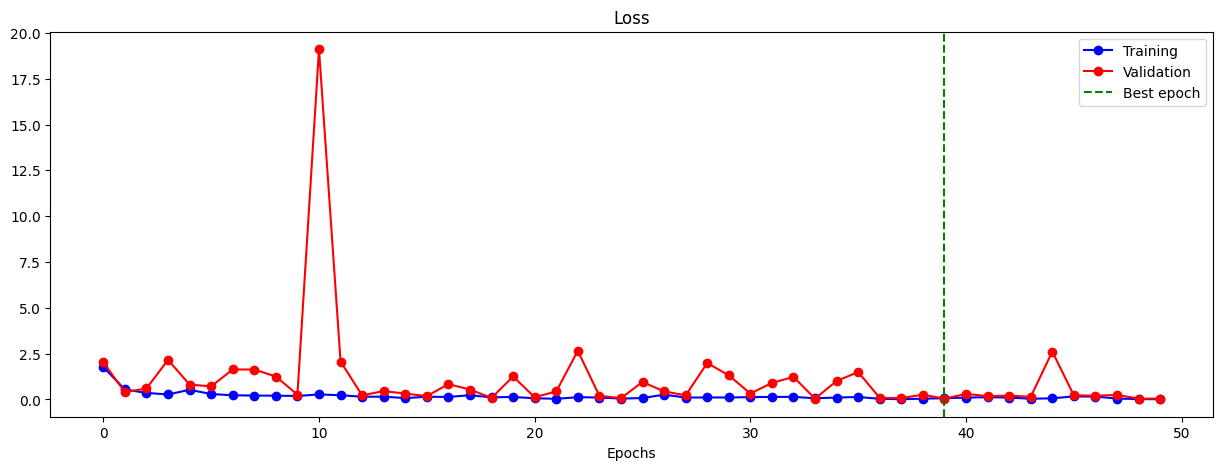

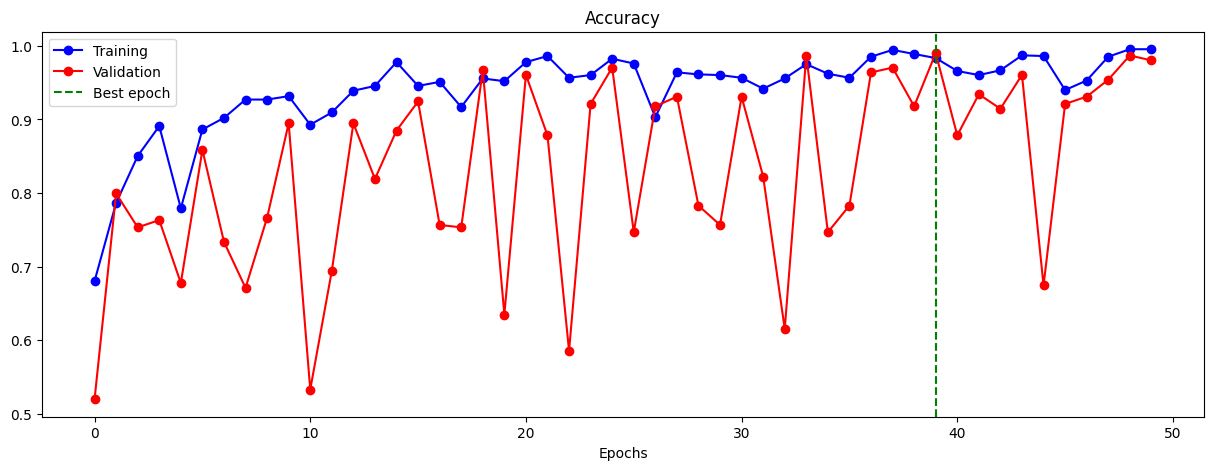

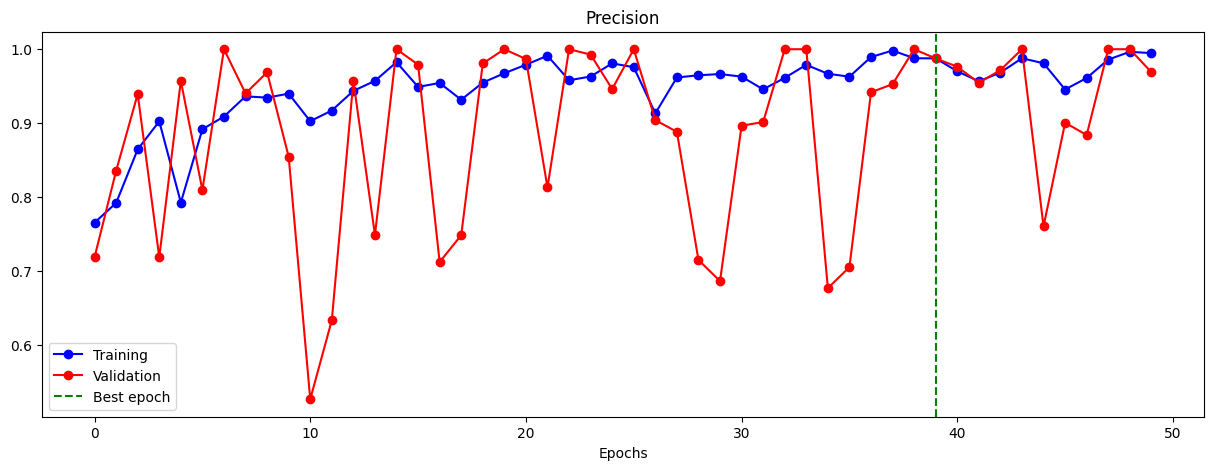

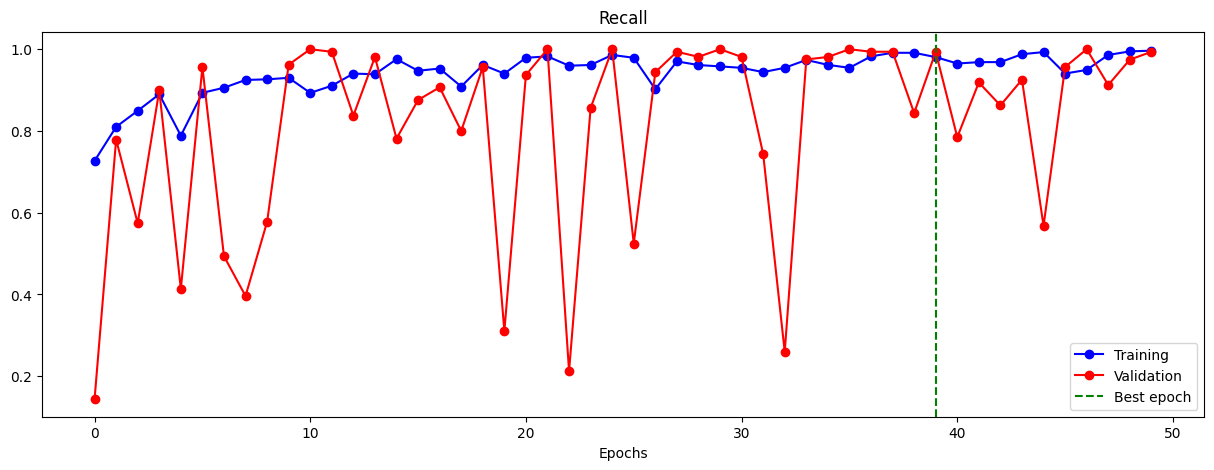

In [32]:
visualize_training_results(history)

In [33]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


20/20 [==============================] - 3s 89ms/step


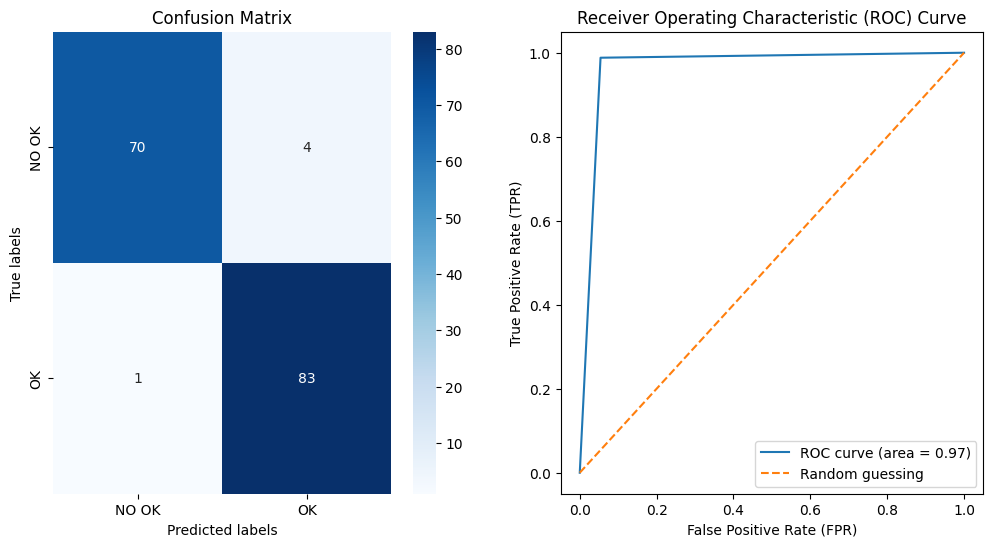

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        74
           1       0.95      0.99      0.97        84

    accuracy                           0.97       158
   macro avg       0.97      0.97      0.97       158
weighted avg       0.97      0.97      0.97       158



In [35]:
plot_metrics(model, test_data)

In [36]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  39
Best loss:  0.06970497965812683
Best accuracy:  0.9833641648292542
Best recall:  0.9807355403900146
Best precision:  0.9876543283462524
Best val_loss:  0.04452469199895859
Best val_accuracy:  0.9901315569877625
Best val_recall:  0.9937106966972351
Best val_precision:  0.987500011920929
